In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from scipy.stats import skew 
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KDTree
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split

import os
print(os.listdir())

import warnings
warnings.filterwarnings('ignore')

['house_price_competition_day_2_failed_trying.ipynb', 'house_price_advanced_view.ipynb', 'addr_kmeans.pkl', 'submission.csv', 'house_price_advanced_models.ipynb', 'my_model_submission.csv1', 'my_model_submission4.csv', 'house_price', 'addr_umap.pkl', 'Day1.ipynb', 'titanic', 'house-prices-advanced-regression-techniques.zip', 'titanic.zip', 'my_model_submission3.csv', 'house_price_competition_view_day2.ipynb', 'my_model_submission0.csv', 'X_umap.npy', 'addr_tfidf.pkl', 'Day2 Housing Price.ipynb', 'pca_model.pkl', 'my_model_submission.csv', 'umap_model.pkl', 'my_model_submission1.csv', 'Untitled1.ipynb', 'house_price_view.ipynb', 'home-data-for-ml-course.zip', '.ipynb_checkpoints', 'home-data-for-ml-course', 'house_price.ipynb', 'my_model_submission2.csv']


In [2]:
train = pd.read_csv('house_price/dataset.csv')
test = pd.read_csv('house_price/test.csv')
print ("Data is loaded!")

Data is loaded!


In [3]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('sale_price')
quantitative.remove('id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [4]:
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
print(missing)

sale_nbr       42182
subdivision    17550
submarket       1717
dtype: int64


In [5]:
sns.set_style("whitegrid")
missing = test.isnull().sum()
missing = missing[missing > 0]
print(missing)

sale_nbr       42412
subdivision    17550
submarket       1718
dtype: int64


In [6]:
def dataset_fill_null(obj):
    obj['subdivision'].fillna('Unknown', inplace=True)
    obj.drop(columns=['sale_nbr'], inplace=True)
    obj['submarket'].fillna('Unknown', inplace=True)


dataset_fill_null(train)
dataset_fill_null(test)
print(train.shape)
print(test.shape)

(200000, 46)
(200000, 45)


In [7]:
# 构造原始地址字段
train_ID = train['id']
test_ID = test['id']
# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)
# Deleting outliers
train.reset_index(drop=True, inplace=True)
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["sale_price"] = np.log1p(train["sale_price"])
y = train.sale_price.reset_index(drop=True)

In [8]:
def preprocess_and_encode(df, y=None, drop_high_card=True):
    df = df.copy()
    
    # ================= 清洗阶段 ================= #
    addresses = (df['city'].fillna('') + ' ' + df['subdivision'].fillna('')).str.lower()
    
    # 分词（空格切）
    # 用 CountVectorizer 可以保留频率稀疏性
    
    vectorizer = CountVectorizer(
        max_features=1000,         # 可调大小
        stop_words=None,      # 去常见词
        token_pattern=r'\b\w+\b',  # 标准单词
        ngram_range=(1, 2)         # 一元和二元组都试试
    )
    address_vecs = vectorizer.fit_transform(addresses)
    
    address_df = pd.DataFrame(address_vecs.toarray(), columns=vectorizer.get_feature_names_out())
    address_df.index = df.index
    df = pd.concat([df, address_df], axis=1)
    df = df.drop(columns=['city', 'subdivision'])

    # 使用同一个 address_vecs（CountVectorizer 输出）
    svd = TruncatedSVD(n_components=50, random_state=42)
    address_pca = svd.fit_transform(address_vecs)
    
    # 转成 DataFrame 并拼接
    pca_df = pd.DataFrame(address_pca, columns=[f'address_pca_{i+1}' for i in range(address_pca.shape[1])], index=df.index)
    df = pd.concat([df, pca_df], axis=1)

    # 补充缺失类别为 'None'
    cat_cols = df.select_dtypes(include=['object', 'category', 'string']).columns
    
    for col in cat_cols:
        df[col] = df[col].fillna('None')

    # 填充数值缺失为 0
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        df[col] = df[col].fillna(0)

    # 拆解日期特征
    if 'sale_date' in df.columns:
        df['sale_year'] = pd.to_datetime(df['sale_date']).dt.year
        df['sale_month'] = pd.to_datetime(df['sale_date']).dt.month
        df = df.drop(columns='sale_date')

    df['house_age'] = df['sale_year'] - df['year_built']
    df['reno_age'] = df['sale_year'] - df['year_reno']
    df['has_reno'] = (df['year_reno'] > 0).astype(int)
    df['land_imp_ratio'] = df['land_val'] / (df['imp_val'] + 1e-5)
    df['sale_date'] = pd.to_datetime(df['sale_date'])
    df['time_since_sale'] = (df['sale_date'].max() - df['sale_date']).dt.days / 30  # 单位：月



    # ================= 编码阶段 ================= #
    cat_cols = df.select_dtypes(include='object').columns
    low_card_cols = []
    high_card_cols = []
    
    for col in cat_cols:
        try:
            n_unique = df[col].nunique()
            if isinstance(n_unique, (int, np.integer)):
                if n_unique <= 50:
                    low_card_cols.append(col)
                else:
                    high_card_cols.append(col)
            else:
                print(f"[跳过] {col} 的 nunique 结果不是标量: {n_unique}")
        except Exception as e:
            print(f"[异常] {col}: {e}")


    # One-hot 编码
    X_cat = pd.get_dummies(df[low_card_cols], dummy_na=True)

    # Target 编码
    if y is not None and high_card_cols:
        encoder = ce.TargetEncoder()
        X_target = encoder.fit_transform(df[high_card_cols], y)
        X_target.columns = [f"{col}_te" for col in high_card_cols]
    else:
        X_target = pd.DataFrame(index=df.index)

    # 数值标准化
    num_cols = df.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    X_num_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols, index=df.index)

    # 拼接所有
    X_final_df = pd.concat([X_num_scaled, X_cat, X_target], axis=1)

    return X_final_df


In [9]:
def add_knn_price_features(df, base_df=None, lat_col='latitude', lon_col='longitude',
                           target_col='target', ks=[5, 10, 20]):
    if base_df is None:
        base_df = df  # 默认自己为近邻池

    coords_query = df[[lat_col, lon_col]].values
    coords_base = base_df[[lat_col, lon_col]].values
    tree = KDTree(coords_base, metric='euclidean')

    base_targets = base_df[target_col].values
    knn_features = {}

    for k in ks:
        dists, indices = tree.query(coords_query, k=k)
        neighbor_targets = base_targets[indices]

        knn_features[f'knn_price_mean_{k}'] = neighbor_targets.mean(axis=1)
        knn_features[f'knn_price_std_{k}'] = neighbor_targets.std(axis=1)
        knn_features[f'knn_price_range_{k}'] = neighbor_targets.max(axis=1) - neighbor_targets.min(axis=1)

    for col, val in knn_features.items():
        df[col] = val

    return df


In [10]:
def add_radius_knn_features(df, base_df, lat_col='latitude', lon_col='longitude', target_col='target', radius=0.01, max_neighbors=100):
    coords = np.radians(base_df[[lat_col, lon_col]])
    tree = BallTree(coords, metric='haversine')  # 地理距离计算更准

    df_coords = np.radians(df[[lat_col, lon_col]])
    indices = tree.query_radius(df_coords, r=radius)

    # 每个样本找到若干邻居索引后，聚合
    agg_means, agg_stds, agg_counts = [], [], []
    base_targets = base_df[target_col].values

    for idxs in indices:
        if len(idxs) > 1:
            if len(idxs) > max_neighbors:
                idxs = idxs[:max_neighbors]
            neigh_vals = base_targets[idxs]
            agg_means.append(np.mean(neigh_vals))
            agg_stds.append(np.std(neigh_vals))
            agg_counts.append(len(idxs))
        else:
            agg_means.append(np.nan)
            agg_stds.append(np.nan)
            agg_counts.append(0)

    df['radius_knn_mean'] = agg_means
    df['radius_knn_std'] = agg_stds
    df['radius_knn_count'] = agg_counts

    return df


In [11]:
def add_knn_price_features_radius(df, base_df, lat_col='latitude', lon_col='longitude',
                                   target_col='sale_price', radius=0.01, max_neighbors=100):
    df = df.copy()
    
    coords_query = df[[lat_col, lon_col]].astype(np.float32).values
    coords_base = base_df[[lat_col, lon_col]].astype(np.float32).values
    targets_base = base_df[target_col].astype(np.float32).values

    tree = KDTree(coords_base, leaf_size=40, metric='euclidean')
    neighbor_indices = tree.query_radius(coords_query, r=radius)

    means, stds, ranges = [], [], []

    for i, inds in enumerate(neighbor_indices):
        # 排除自身（仅当 base_df 是 df）
        if base_df is df:
            inds = inds[inds != i]
        
        if len(inds) == 0:
            means.append(np.nan)
            stds.append(np.nan)
            ranges.append(np.nan)
        else:
            if len(inds) > max_neighbors:
                inds = inds[:max_neighbors]
            vals = targets_base[inds]
            means.append(np.mean(vals))
            stds.append(np.std(vals))
            ranges.append(np.max(vals) - np.min(vals))

    df[f'knn_radius_mean'] = means
    df[f'knn_radius_std'] = stds
    df[f'knn_radius_range'] = ranges

    return df

In [12]:
# 应用预处理
# 对训练集（自己做自己）
train = add_knn_price_features(train, base_df=train, target_col='sale_price')
# 对测试集（用训练集做 base）
test = add_knn_price_features(test, base_df=train, target_col='sale_price')

train = add_knn_price_features_radius(train, base_df=train, target_col='sale_price')
# 对测试集（用训练集做 base）
test = add_knn_price_features_radius(test, base_df=train, target_col='sale_price')

train_features = train.drop(['sale_price'], axis=1)
test_features = test

features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)
print([col for col in features.columns if 'knn' in col])

X_final = preprocess_and_encode(features)

(400000, 56)
['knn_price_mean_5', 'knn_price_std_5', 'knn_price_range_5', 'knn_price_mean_10', 'knn_price_std_10', 'knn_price_range_10', 'knn_price_mean_20', 'knn_price_std_20', 'knn_price_range_20', 'knn_radius_mean', 'knn_radius_std', 'knn_radius_range']


In [13]:
print(X_final.shape)

(400000, 1134)


In [14]:
X = X_final.iloc[:len(train_features)].reset_index(drop=True)
X_sub = X_final.iloc[len(train_features):].reset_index(drop=True)
print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (200000, 1134) y (200000,) X_sub (200000, 1134)


In [15]:
protected_cols = []
overfit = [i for i in X.columns if i not in protected_cols and X[i].value_counts().iloc[0] / len(X) * 100 > 99.94]
print(overfit)

['join_status_nan', 'submarket_nan']


In [16]:
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (200000, 1132) y (200000,) X_sub (200000, 1132)


In [17]:
def get_lgb_quantile_model(alpha):
    return lgb.LGBMRegressor(
        objective='quantile',
        alpha=alpha,
        n_jobs=-1,
        num_leaves=4,
        learning_rate=0.01,
        n_estimators=5000,
        max_bin=200,
        bagging_fraction=0.75,
        bagging_freq=5,
        bagging_seed=7,
        feature_fraction=0.2,
        feature_fraction_seed=7,
        min_data_in_leaf=20,   # 调大一点防过拟合 tail
        verbose=-1
    )


In [18]:
import lightgbm as lgb

def train_quantile_model(X, y, quantile):
    params = {
        'objective': 'quantile',
        'alpha': quantile,
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'min_data_in_leaf': 30,
        'verbosity': -1
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X, y)
    return model


In [19]:
def interval_score(y_true, lower, upper, alpha=0.1):
    """
    Compute Wα for a given prediction interval [lower, upper] and true values y.
    """
    interval_width = upper - lower
    below = y_true < lower
    above = y_true > upper
    inside = (lower <= y_true) & (y_true <= upper)
    
    penalty = np.zeros_like(y_true, dtype=float)
    penalty[below] = (2 / alpha) * (lower[below] - y_true[below])
    penalty[above] = (2 / alpha) * (y_true[above] - upper[above])

    return np.mean(interval_width + penalty)


In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_lower = get_lgb_quantile_model(alpha=0.05)
model_upper = get_lgb_quantile_model(alpha=0.95)

model_lower.fit(X_train, y_train)
model_upper.fit(X_train, y_train)

pred_lower = model_lower.predict(X_val)
pred_upper = model_upper.predict(X_val)

score = interval_score(y_val, pred_lower, pred_upper, alpha=0.1)
print(f"W_alpha score: {score:.5f}")

KeyboardInterrupt: 

In [22]:
model_lower = train_quantile_model(X_train, y_train, quantile=0.05)
model_upper = train_quantile_model(X_train, y_train, quantile=0.95)

pred_lower = model_lower.predict(X_val)
pred_upper = model_upper.predict(X_val)

score = interval_score(y_val, pred_lower, pred_upper, alpha=0.1)
print(f"W_alpha score: {score:.5f}")

KeyboardInterrupt: 

In [23]:
model_lower = train_quantile_model(X, y, quantile=0.05)
model_upper = train_quantile_model(X, y, quantile=0.95)




In [24]:
pred_lower = model_lower.predict(X_sub)
pred_upper = model_upper.predict(X_sub)



In [27]:
pred_lower = np.expm1(pred_lower)
pred_upper = np.expm1(pred_upper)

submission = pd.DataFrame({
    'id': test_ID,  # test 原始数据中的 ID
    'pi_lower': pred_lower,  # 下限预测
    'pi_upper': pred_upper   # 上限预测
})
submission.to_csv('submission.csv', index=False)

In [28]:
def best_features(model):
    # 获取特征重要性
    importance = model.feature_importances_
    features = X_train.columns
    
    # 打包成 DataFrame
    feat_imp = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # 显示前 30 个最重要的特征
    print(feat_imp.head(50))


best_features(model_lower)
best_features(model_upper)

                 feature  importance
1098           sale_year        2029
37      knn_price_mean_5        1751
5               land_val        1131
39     knn_price_range_5        1096
10                  sqft         971
38       knn_price_std_5         953
6                imp_val         952
1100           house_age         850
1               latitude         799
7             year_built         719
9               sqft_lot         670
11                sqft_1         614
40     knn_price_mean_10         584
43     knn_price_mean_20         516
1101            reno_age         498
2              longitude         498
46       knn_radius_mean         493
1103      land_imp_ratio         469
1099          sale_month         455
42    knn_price_range_10         423
45    knn_price_range_20         411
41      knn_price_std_10         397
44      knn_price_std_20         375
47        knn_radius_std         363
13                 grade         353
22             gara_sqft         343
1

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_pinball_loss, make_scorer

param_grid = {
    'num_leaves': [4, 8, 16],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [1000, 2000],
    'feature_fraction': [0.6, 0.8],
    'bagging_fraction': [0.6, 0.8],
    'min_data_in_leaf': [20, 30],
}

def pinball_scorer(y_true, y_pred):
    return -mean_pinball_loss(y_true, y_pred, alpha=0.05)

scorer = make_scorer(pinball_scorer, greater_is_better=True)


model = lgb.LGBMRegressor(objective='quantile', alpha=0.05)
grid = GridSearchCV(model, param_grid, cv=3, scoring=scorer)
grid.fit(X, y)

print(grid.best_params_)


{'bagging_fraction': 0.6, 'feature_fraction': 0.6, 'learning_rate': 0.05, 'min_data_in_leaf': 30, 'n_estimators': 2000, 'num_leaves': 16}


In [35]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

params = {
    'objective': 'quantile',
    'alpha': 0.05,  # 下限模型
    'num_leaves': 16,
    'learning_rate': 0.05,
    'n_estimators': 2000,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.6,
    'min_data_in_leaf': 30,
    'verbosity': -1
}

model_lower = lgb.LGBMRegressor(**params)
model_lower.fit(X_train, y_train)

# 上限只改 alpha
params['alpha'] = 0.95
model_upper = lgb.LGBMRegressor(**params)
model_upper.fit(X_train, y_train)

pred_lower = model_lower.predict(X_val)
pred_upper = model_upper.predict(X_val)

score = interval_score(y_val, pred_lower, pred_upper, alpha=0.1)
print(f"W_alpha score: {score:.5f}")

ValueError: ('Lengths must match to compare', (40000,), (200000,))

In [37]:
pred_lower = model_lower.predict(X_val)
pred_upper = model_upper.predict(X_val)

score = interval_score(y_val, pred_lower, pred_upper, alpha=0.1)
print(f"W_alpha score: {score:.5f}")

W_alpha score: 0.56340


In [30]:
def try_param_set(X, y, param_overrides):
    base_params = {
        'objective': 'quantile',
        'alpha': 0.05,
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'min_data_in_leaf': 30,
        'verbosity': -1
    }
    base_params.update(param_overrides)
    model = lgb.LGBMRegressor(**base_params)
    scores = cv_rmse(model, X)
    return np.mean(scores), param_overrides


In [31]:
for leaves in [4, 8, 16]:
    for lr in [0.01, 0.05]:
        score, params = try_param_set(X, y, {'num_leaves': leaves, 'learning_rate': lr})
        print(score, params)


NameError: name 'cv_rmse' is not defined

In [38]:
other_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 4,
    'max_features': 'sqrt',
    'min_samples_leaf': 15,
    'min_samples_split': 10,
    'random_state': 42
}

gbr_lower = GradientBoostingRegressor(loss='quantile', alpha=0.05, **other_params)
gbr_upper = GradientBoostingRegressor(loss='quantile', alpha=0.95, **other_params)

gbr_lower.fit(X_train, y_train)
gbr_upper.fit(X_train, y_train)

pred_lower = gbr_lower.predict(X_val)
pred_upper = gbr_upper.predict(X_val)

# 评估 W_alpha
score = interval_score(y_val, pred_lower, pred_upper, alpha=0.1)
print(f"W_alpha score: {score:.5f}")

W_alpha score: 0.67446


In [40]:
best_features(model_lower)
best_features(model_upper)

                 feature  importance
1098           sale_year        1583
37      knn_price_mean_5        1277
5               land_val         898
6                imp_val         883
38       knn_price_std_5         844
10                  sqft         839
39     knn_price_range_5         836
1101            reno_age         834
1100           house_age         795
40     knn_price_mean_10         731
7             year_built         719
1               latitude         683
9               sqft_lot         630
11                sqft_1         599
44      knn_price_std_20         527
2              longitude         505
1103      land_imp_ratio         504
46       knn_radius_mean         492
43     knn_price_mean_20         466
42    knn_price_range_10         458
41      knn_price_std_10         456
1099          sale_month         435
22             gara_sqft         401
45    knn_price_range_20         399
47        knn_radius_std         367
13                 grade         315
4

In [42]:
errors = (y_val < pred_lower) | (y_val > pred_upper)
error_cases = X_val[errors]
error_cases['sale_year']

65426    -0.690261
84660     0.875144
110852   -0.038009
156518    1.005594
132176    0.875144
            ...   
10230    -1.342513
7083     -1.603414
104804    0.744693
73767    -1.342513
48780    -1.212062
Name: sale_year, Length: 4495, dtype: float64

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_top_features_loss(X_val, y_val, pred_lower, pred_upper, feature_importance, top_n=10):
    # 1. 前 top N 特征
    top_feats = feature_importance['feature'].iloc[:top_n].tolist()
    
    # 2. 计算每行 W_alpha 损失
    alpha = 0.1
    interval_width = pred_upper - pred_lower
    below = (y_val < pred_lower).astype(int)
    above = (y_val > pred_upper).astype(int)
    loss = interval_width + (2 / alpha) * (below + above)

    df_loss = X_val[top_feats].copy()
    df_loss['loss'] = loss

    # 3. 分组统计并画图
    for feat in top_feats:
        df_loss['group'] = pd.qcut(df_loss[feat], q=10, duplicates='drop')
        plt.figure(figsize=(10, 4))
        sns.boxplot(x='group', y='loss', data=df_loss)
        plt.xticks(rotation=45)
        plt.title(f'W(alpha=0.1) Loss by {feat}')
        plt.tight_layout()
        plt.show()


In [45]:
def best_features(model):
    # 获取特征重要性
    importance = model.feature_importances_
    features = X_train.columns
    
    # 打包成 DataFrame
    feat_imp = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # 显示前 30 个最重要的特征
    return (feat_imp.head(30))


feat_imp_df = best_features(model_lower)
feat_imp_df1 = best_features(model_upper)

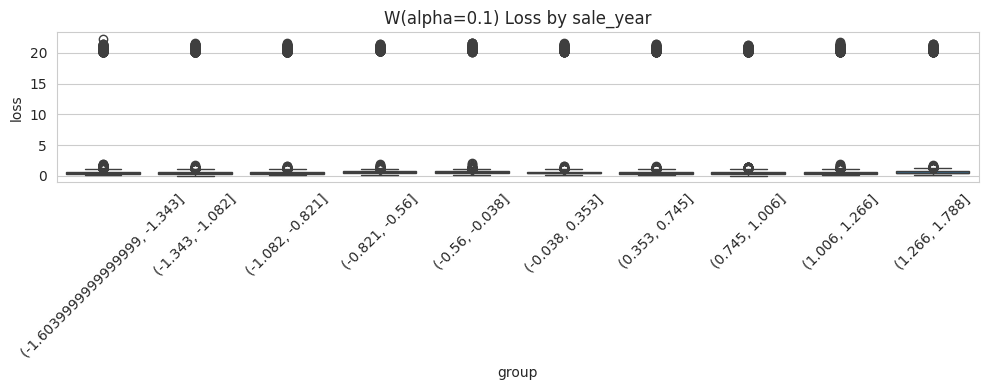

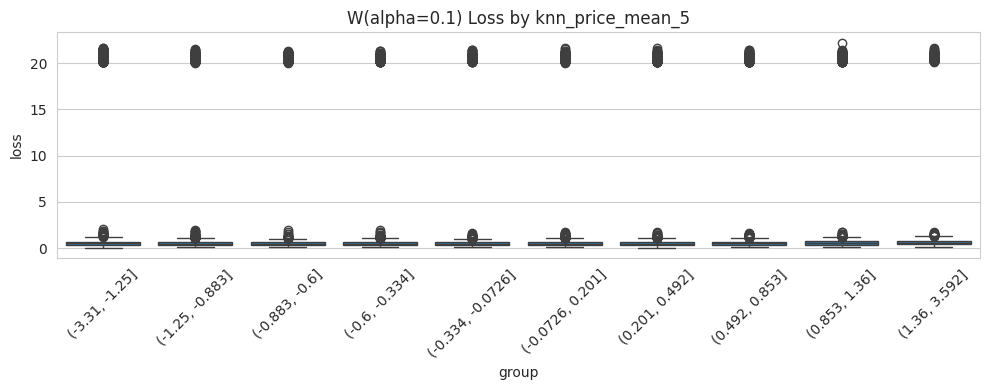

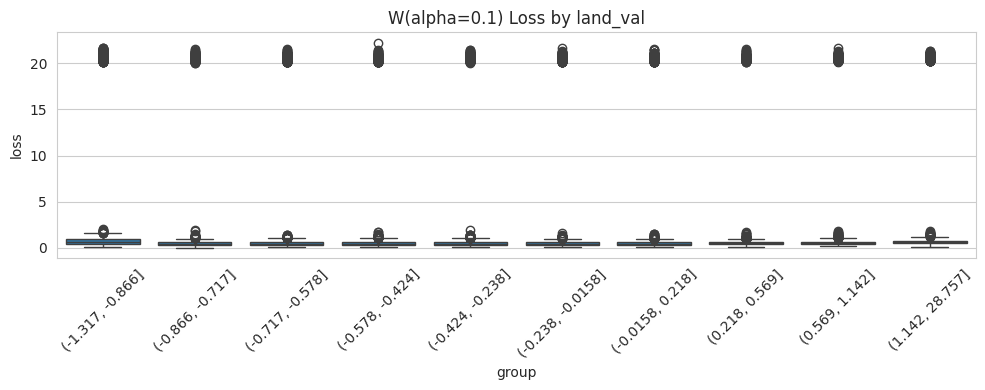

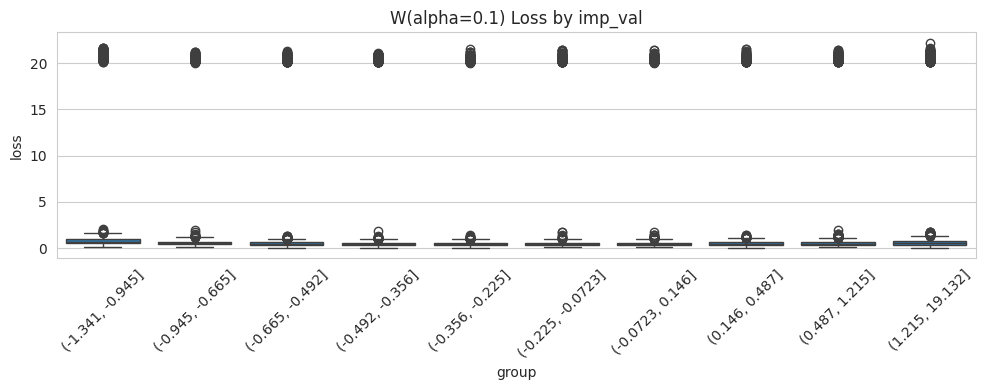

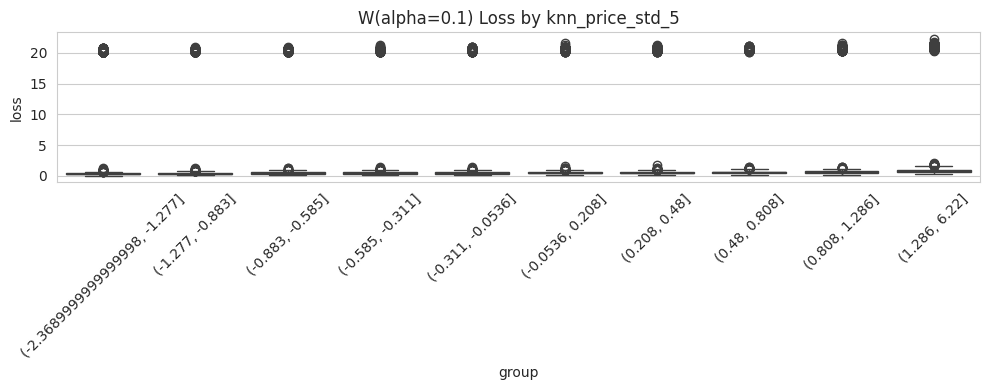

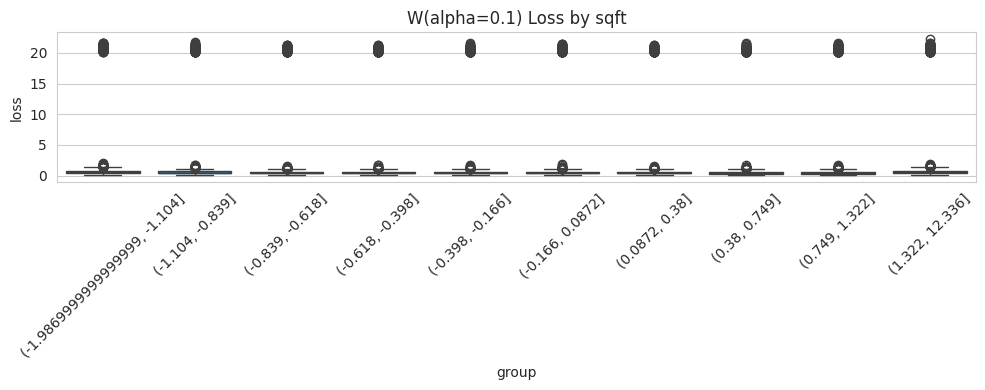

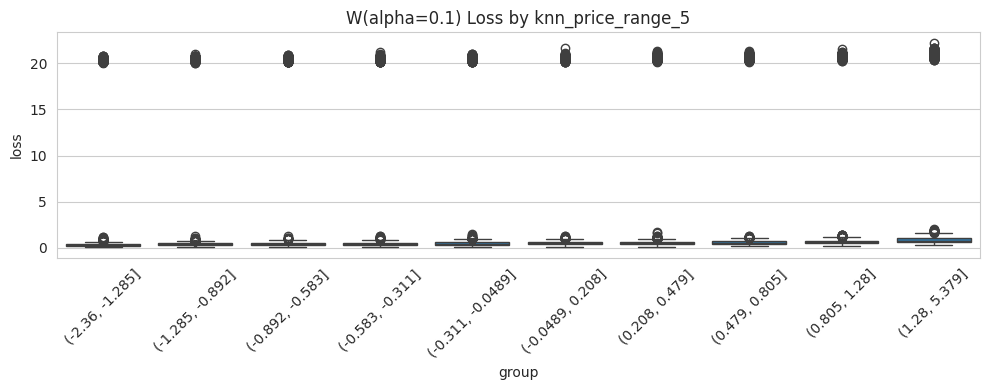

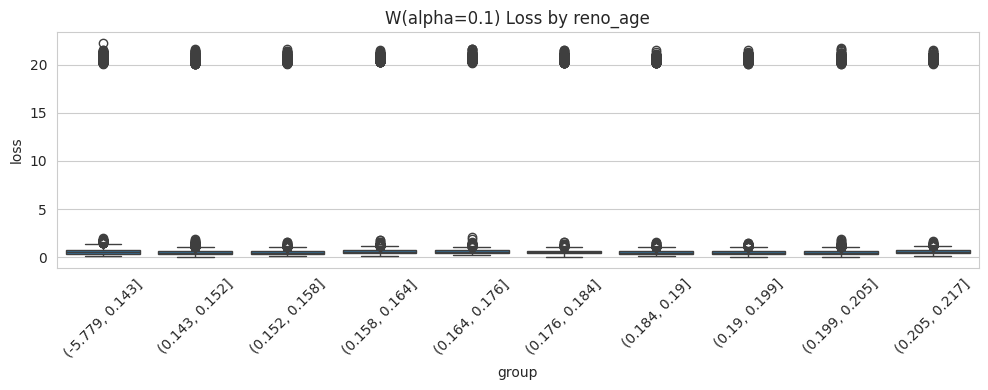

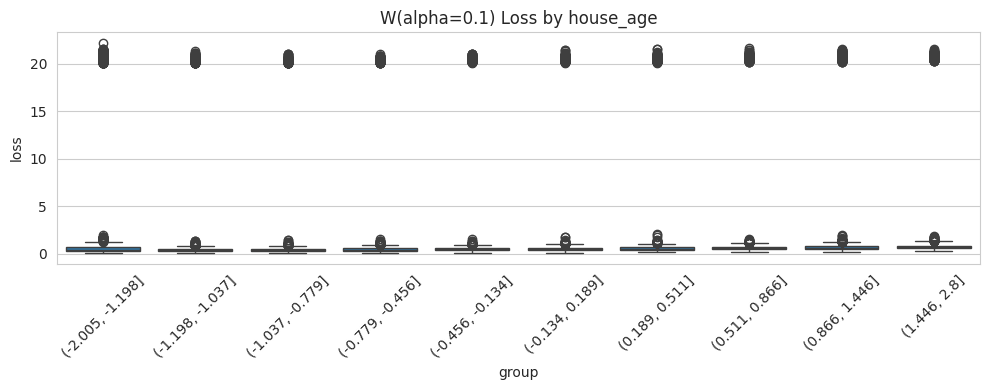

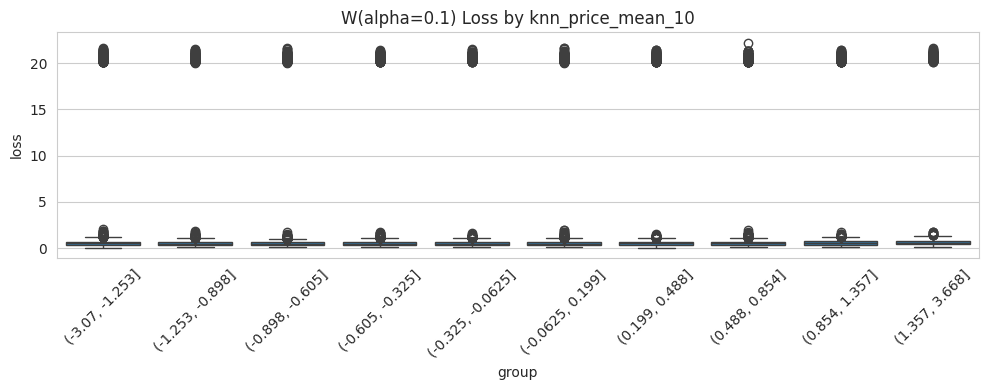

In [46]:
analyze_top_features_loss(
    X_val=X_val,
    y_val=y_val,
    pred_lower=pred_lower,
    pred_upper=pred_upper,
    feature_importance=feat_imp_df,
    top_n=10
)


In [ ]:
def best_features(model):
    # 获取特征重要性
    importance = model.feature_importances_
    features = X_train.columns
    
    # 打包成 DataFrame
    feat_imp = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # 显示前 30 个最重要的特征
    return (feat_imp.head(30))


best_features(model_lower)
best_features(model_upper)


In [ ]:
[k for k in X.columns if 'knn_price' in k]

In [ ]:
def add_knn_price_features(df, lat_col='latitude', lon_col='longitude', target_col='target', ks=[5, 10, 20]):
    coords = df[[lat_col, lon_col]].values
    target = df[target_col].values
    tree = KDTree(coords, metric='euclidean')

    # 用于保存所有新特征
    knn_features = {}

    for k in ks:
        # 找最近邻（包括自己）
        dists, indices = tree.query(coords, k=k+1)  # k+1 是因为自己也算在内

        # 排除自身
        neighbor_targets = np.array([target[idxs[1:]] for idxs in indices])

        # 聚合统计
        knn_features[f'knn_price_mean_{k}'] = neighbor_targets.mean(axis=1)
        knn_features[f'knn_price_std_{k}'] = neighbor_targets.std(axis=1)
        knn_features[f'knn_price_range_{k}'] = neighbor_targets.max(axis=1) - neighbor_targets.min(axis=1)

    # 加入原始 df
    for col_name, values in knn_features.items():
        df[col_name] = values

    return df 


In [ ]:
# 假设 df 中已经有 latitude、longitude、target（真实价格）列
df = add_knn_price_features(train, target_col='sale_price', ks=[5, 10, 20])


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_knn_feature(df, feature_col='knn_price_mean_5'):
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(df['longitude'], df['latitude'], 
                     c=df[feature_col], cmap='viridis', s=5)
    plt.colorbar(sc, label=feature_col)
    plt.title(f'Spatial distribution of {feature_col}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.show()


In [ ]:
plot_knn_feature(df, 'knn_price_mean_20')
plot_knn_feature(df, 'knn_price_mean_10')
plot_knn_feature(df, 'knn_price_mean_5')

In [ ]:

df = train.copy()
addresses = (df['city'].fillna('') + ' ' + df['subdivision'].fillna('')).str.lower()

# 分词（空格切）
# 用 CountVectorizer 可以保留频率稀疏性

vectorizer = CountVectorizer(
    max_features=1000,         # 可调大小
    stop_words=None,      # 去常见词
    token_pattern=r'\b\w+\b',  # 标准单词
    ngram_range=(1, 2)         # 一元和二元组都试试
)
address_vecs = vectorizer.fit_transform(addresses)

# 得到 token -> index 映射
tokens = vectorizer.get_feature_names_out()
# 每个 token 的总出现频率（在所有样本中出现的总次数）
token_freq = np.asarray(address_vecs.sum(axis=0)).ravel()

# 排序
sorted_idx = np.argsort(-token_freq)
top_tokens = [(tokens[i], token_freq[i]) for i in sorted_idx[:200]]

# 展示前 50 个 token 和它们的频率
for t, f in top_tokens:
    print(f"{t}: {f}")
svd = TruncatedSVD(n_components=100, random_state=42)
address_pca = svd.fit_transform(address_vecs)

# 累计解释方差
explained = np.cumsum(svd.explained_variance_ratio_)
plt.plot(range(1, len(explained) + 1), explained)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Truncated SVD on Address')
plt.grid(True)
plt.show()


In [ ]:
待处理特征：
改造时间距离现在多少年
地址经纬度做近邻，最好找出价格最高的中心点
尝试销售年份和submarke捆绑，销售月份和地区捆绑
PCA提取地址主成分

节假日等


In [ ]:
尝试模型：
NN：TabNet / DNN


In [ ]:
Ensemble 评估（集成）